In [3]:
import os
import subprocess
import sys

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

from hydra import compose, initialize, core
from omegaconf import OmegaConf

from src.custom_utils import S3Helper

## Hydra

In [4]:
core.global_hydra.GlobalHydra.instance().clear()
initialize(version_base='1.2', config_path='../src/config', job_name='processing')
config = OmegaConf.to_container(compose(config_name='main'), resolve=True)

## Short-Term Forecasting Horizon

For short-term forecasting horizon (two weeks or 14 days), the processing steps are summarized below:

| Section | Description |
| ------- | ----------- |
| **Purpose** | To process the most recent data, specifically from the year 2023, for short-horizon forecasting tasks. |
| **Data Ingestion** | Reads raw data from an S3 bucket using a specified input key. |
| **Configuration Parameters** | Retrieves `start_date`, `end_date`, and `forecast_horizon` from the configuration settings. These are set to capture the period within 2023 relevant to the forecasting task. |
| **Data Filtering** | Filters the ingested data to include only the dates between `start_date` and `end_date`, focusing on the 2023 data subset as the most recent and therefore most relevant for short-term forecasting. |
| **Forecasting Horizon** | Determines the test period indices based on the last `forecast_horizon` number of points from the filtered 2023 data, indicating the immediate future dates for which the forecast is intended. |
| **Data Splitting** | Splits the 2023 data subset into training and test sets. The training set excludes the test period, ensuring the model is not trained on future data it will predict. |
| **Writing to S3** | Writes the training and test sets for the 2023 subset to the S3 bucket in Parquet format, storing them separately to distinguish between the data used for model training and evaluation. |

In [2]:
!poetry run python3 ../src/processing_entry.py --process_task_type short

2023-11-03 22:05:13,526 INFO processing_short: Processing data for short-horizon forecasting
2023-11-03 22:05:14,245 INFO processing_short: Filtering data from 2023-01-01 to 2023-06-30
2023-11-03 22:05:14,246 INFO processing_short: Forecasting horizon: 14
2023-11-03 22:05:14,246 INFO processing_short: Splitting data into train and test sets
2023-11-03 22:05:14,247 INFO processing_short: Train period: 2023-01-01 to 2023-06-16
2023-11-03 22:05:14,247 INFO processing_short: Test period: 2023-06-17 to 2023-06-30
2023-11-03 22:05:14,382 INFO processing_short: Successfully written train data to s3 for short-horizon forecasting
2023-11-03 22:05:14,498 INFO processing_short: Successfully written test data to s3 for short-horizon forecasting


## Medium-to-Long Term Forecasting Horizon

### Handling COVID-19 with Scenario-Based Forecasting

It can be argue that the sudden drop of bus ridership and rail boardings observed in the data (and in the time plot) represents a [structural break](https://en.wikipedia.org/wiki/Structural_break) that is caused by the COVID-19 pandemic. According to the research conducted by Athanasopoulos et al. (2023) and published in the Journal of Travel Research, Volume 62, Issue 1, the biggest challenge presented by the COVID-19 pandemic on any forecasting tasks is an increased level of uncertainly:

> From a statistical modelling and forecasting perspective, these disruptions cause unique challenges. The pandemic has meant that we cannot extrapolate the strong and persistent signals observed in historical tourism time series. The structural break is deep and the path to recovery remains extremely uncertain. 

The authors in this paper argue that historical data from the COVID-19 years cannot be used to forecast without first addressing this structural breakdown:   

> ... the effect of the COVID-19 pandemic is such that historical data cannot be used to project forward without explicitly accounting for the depth and the length of the structural break caused by COVID-19, and the subsequent unknown and unprecedented path to recovery. Both the depth and length of the effect of the pandemic are extremely challenging or even impossible to estimate and predict statistically, and therefore we revert to a novel approach of judgemental forecasting.

In this project, we will develop our own judgmental forecasting methodology, which includes the following steps:

- Determine the earliest and latest dates within the COVID-19 years (i.e., December 2019 and June 2023). These effectively serve as proxies for the length of the structural break.
- Utilize a bootstrapped ETS trained on historical data prior to January 2020 to forecast all observations after.
- Replace all pandemic bus ridership and rail boardings data with the forecast generated by the models. 
- Train models based on two scenarios: one with forecast or "counterfactual" data for Covid-19 and another with original data including the structural breakdown. 

This approach allows us to consider a counterfactual scenario had the COVID-19 pandemic never occurred. Any subsequent models trained on this "counterfactual" data generate forecasts that can be regarded as recovery trajectories. In other words, these forecasts represent the levels of bus ridership and rail boardings that might have been attained if the pandemic had not happened, and they should serve as the benchmark that the city of Chicago should aim to return to.

The objective is to provide more dependable scenario-based forecasts. Consequently, the step involving the training of models to predict the COVID-19 data will be fine-tuned using time series cross-validation.

All of the above log will be handled in the `processing_entry.py` module.

| Step | Medium-Term Forecasting | Long-Term Forecasting |
| ---- | ----------------------- | --------------------- |
| **Data Ingestion** | Reads raw data from an S3 bucket using a specified input key. | Same as medium-term forecasting. |
| **Data Resampling** | Resamples data to a monthly frequency. | Same as medium-term forecasting. |
| **Counterfactual Forecasting** | Uses historical data prior to January 2020 to forecast values after January 2020 using a bootstrapped ETS model. | Same as medium-term forecasting. |
| **Forecast Horizon** | Forecasts 6 months ahead. | Forecasts 36 months ahead. |
| **Data Splitting** | Splits data into training (starting from Jan 2021) and test (from Jan 2023 to Jun 2023) sets. | Splits data into training (starting Jan 2001) and test (from Feb 2021 to Jun 2023) sets. |
| **Data Output** | Writes both original and counterfactual data to S3 in Parquet format. | Same as medium-term forecasting but for a longer horizon. |
| **Scenario-Based Forecasting** | Trains models on counterfactual (forecasted) and original (actual) data to provide recovery trajectory forecasts. | Same as medium-term forecasting but considers a longer historical period. |

In [5]:
cmd = 'poetry run python3 ../src/processing_entry.py --process_task_type long'

proc = subprocess.Popen(cmd, shell=True, stdout=subprocess.PIPE, stderr=subprocess.PIPE)

# Wait for the processes to finish and read the output and error streams
stdout, stderr = proc.communicate()
print('Long processing output:', stdout.decode('utf-8'))

Long processing output: 2023-11-05 20:09:56,427 INFO processing_long: Forecasting counterfactual data for Covid-19
2023-11-05 20:10:39,943 INFO processing_long: Forecasting horizon: 36 months ahead
2023-11-05 20:10:39,944 INFO processing_long: Train period: 2013-01-31 to 2020-06-30
2023-11-05 20:10:39,944 INFO processing_long: Test period: 2020-07-31 to 2023-06-30
2023-11-05 20:10:39,946 INFO processing_long: Splitting data into train and test sets for long-horizon forecasting
2023-11-05 20:10:39,950 INFO processing_long: Successfully split data into train and test sets for long-horizon forecasting
2023-11-05 20:10:40,762 INFO processing_long: Successfully written train data to s3 for long-horizon forecasting
2023-11-05 20:10:40,891 INFO processing_long: Successfully written test data to s3 for long-horizon forecasting



### Comparing Original and Counterfactual Data

In [6]:
s3_helper = S3Helper()

long_data_splits = {}
for data_split in ['train', 'test']:
    long_data_splits[data_split] = s3_helper.read_parquet(f'{os.path.join(config["long"]["output_key"], f"{data_split}.parquet")}')
long_data = pd.concat([long_data_splits['train'], long_data_splits['test']], axis=0)

The original and counterfactual data sets should differ in terms of their values for the most recent years 2020-2023:

In [10]:
long_data.tail(10)

,service_date,original_bus,original_rail_boardings,counterfactual_bus,counterfactual_rail_boardings
260,2022-09-30,507834,368435,796958,730621
261,2022-10-31,497726,351798,787925,727921
262,2022-11-30,452011,330234,754304,704191
263,2022-12-31,364899,250406,602091,531316
264,2023-01-31,420711,292169,695813,625030
265,2023-02-28,453915,301171,742016,670204
266,2023-03-31,475520,320115,759416,666470
267,2023-04-30,459253,326873,731947,680004
268,2023-05-31,499608,356184,762787,686857
269,2023-06-30,472069,376645,714320,692486


For long-term data set:

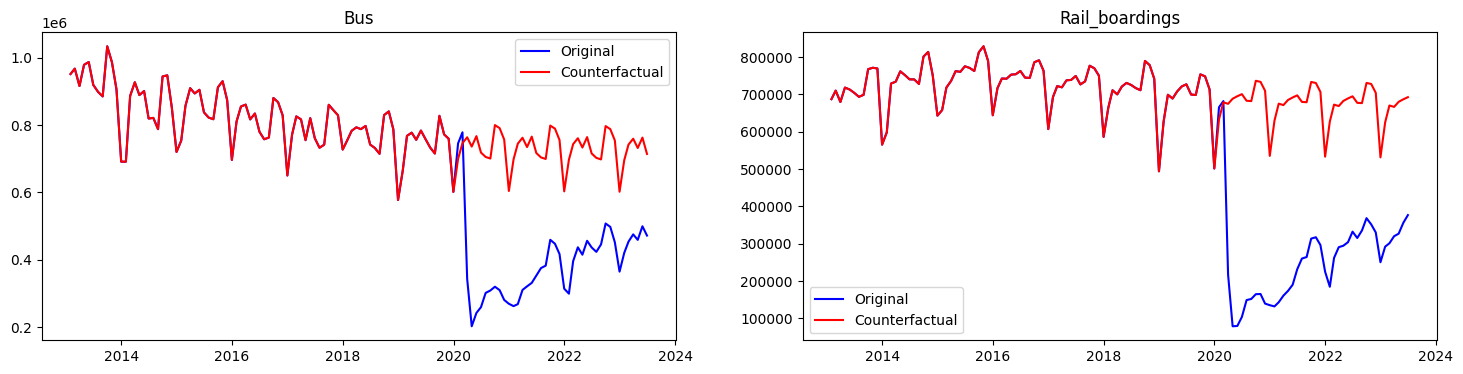

In [11]:
fig, ax = plt.subplots(1, 2, figsize=(18, 4))

for i, series in enumerate(['bus', 'rail_boardings']):
    for data_set, color in zip(['original', 'counterfactual'], ['blue', 'red']):
        ax[i].plot(long_data['service_date'], long_data[f'{data_set}_{series}'], label=data_set.capitalize(), color=color)
        ax[i].set_title(series.capitalize())
        ax[i].legend()